# Sketch out a Map for Timeseries and Find Good Places #

In [166]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import viz_tools, places, nc_tools, geo_tools

from importlib import reload

%matplotlib inline

## Get Grid Information from Bathymetry File ##

In [167]:
grid = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathymetry_201702.nc')
bathy = grid.variables['Bathymetry'][:]
nav_lon = grid.variables['nav_lon'][:]
nav_lat = grid.variables['nav_lat'][:]

## Current Places + S3 ##

In [168]:
S3_lat = 49 + 7.5/60.
S3_lon = - (123 + 33.5/60.)

In [169]:
def nearest_search(nav_lon, nav_lat, stn_lon, stn_lat):
    '''
    ==========================================================
    Search the nearest grid point for a given station
        method: cKDTree (scipy.spatial.cKDTree)
        input: latitude and longitude as degrees
            ------- Yingkai Sha <yingkai@eos.ubc.ca>
    ----------------------------------------------------------
        stn_indx, stn_indy = nearest_search(nav_lon, nav_lat,
             stn_lon, stn_lat)
    ==========================================================
    '''
    from scipy.spatial import cKDTree # <-- The only function uses cKDTree
    # Create KDTree
    grids_list = list(zip(nav_lon.ravel(), nav_lat.ravel()))
    point_list = list(zip(stn_lon, stn_lat))
    domainTree = cKDTree(grids_list)
    # Nearest search
    _, index_flat = domainTree.query(point_list)
    stn_indx, stn_indy = np.unravel_index(index_flat, np.shape(nav_lon))
    return stn_indx, stn_indy

In [170]:
%%timeit
index_x, index_y = nearest_search(nav_lon, nav_lat, [S3_lon], [S3_lat])

669 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
index_x, index_y = nearest_search(nav_lon, nav_lat, [S3_lon], [S3_lat])
print (index_x, index_y)

[450] [258]


In [172]:
%%timeit
index_geo_x, index_geo_y = geo_tools.find_closest_model_point(S3_lon, S3_lat, nav_lon, nav_lat)

2.35 ms ± 66.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [173]:
index_geo_x, index_geo_y = geo_tools.find_closest_model_point(S3_lon, S3_lat, nav_lon, nav_lat)
print(index_geo_x, index_geo_y)

450 258


In [174]:
index_geo_x, index_geo_y = geo_tools.find_closest_model_point(-(123+21/60.), (49+5/60.), nav_lon, nav_lat)
print(index_geo_x, index_geo_y)

427 283


For a single point, find_closest_model_point is 300x faster than nearest_search

S3 was added to places.py

In [175]:
def background_map():
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap('Blues')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(bathy, cmap=cmap, vmax=1000.)
    return ax

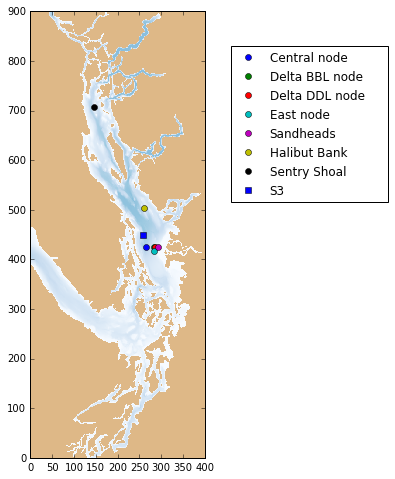

In [176]:
water_places = ['Central node', 'Delta BBL node', 'Delta DDL node', 'East node','Sandheads', \
               'Halibut Bank', 'Sentry Shoal', 'S3']

ax = background_map()

for countpoint, place in enumerate(water_places):
    point = places.PLACES[place]['NEMO grid ji']
    if countpoint < 7:
        ax.plot(point[1], point[0], 'o', label=place)
    else:
        ax.plot(point[1], point[0], 's', label=place)

ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.15, 0.82, 0.9, .102),
    ncol=1,
    mode="expand",
    borderaxespad=0.,
    numpoints=1);

## Load Debby's Sampling Points

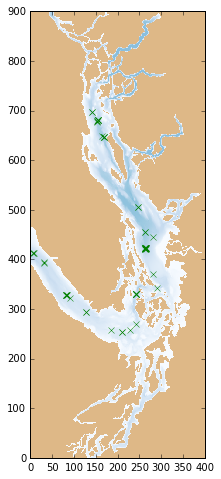

In [177]:
data = np.loadtxt('/ocean/ssahu/MEOPAR/salishseasprint/debby_stations.txt')
ax = background_map()
debby_x = np.empty(data.shape[0])
debby_y = np.empty_like(debby_x)
for i, datum in enumerate(data):
    debby_y[i], debby_x[i] = geo_tools.find_closest_model_point(datum[7], datum[6], nav_lon, nav_lat)
ax.plot(debby_x, debby_y, 'gx')

## Load Vector Sampling Points

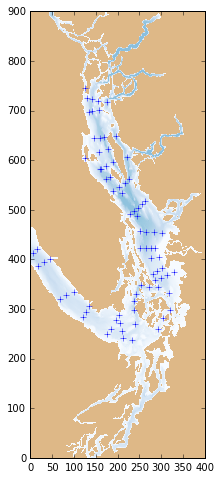

In [178]:
vector_data_file = '/ocean/sallen/allen/research/MEOPAR/vector_stations.txt'
data = np.loadtxt(vector_data_file, usecols=(1, 2, 3, 4))
ax = background_map()
vector_x = np.empty(data.shape[0])
vector_y = np.empty_like(vector_x)
for i, datum in enumerate(data):
    vector_y[i], vector_x[i] = geo_tools.find_closest_model_point(
        -(datum[2] + datum[3] / 60.), datum[0] + datum[1] / 60., nav_lon,
        nav_lat)
ax.plot(vector_x, vector_y, '+')
# and save the lines for identifying the stations later
f = open(vector_data_file)
vectorlines = f.readlines()

## Now look for regularly sampled station inside Tereza's Clusters

In [179]:
biology = nc.Dataset('/ocean/ssahu/MEOPAR/salishseasprint/biology_clusters.nc')

d_stn_x = biology.variables['stn_x'][:]
d_stn_y = biology.variables['stn_y'][:]
bio_non_norm = biology.variables['bio_non_norm'][:]

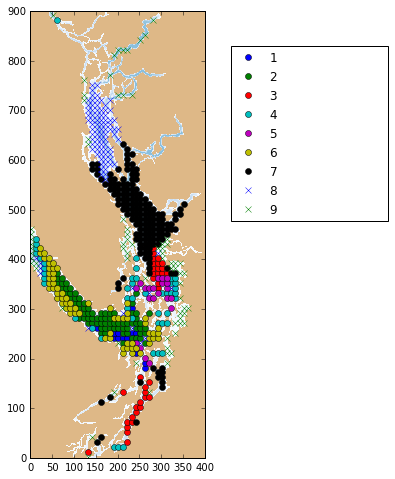

In [180]:
ax = background_map()

for cluster in range(1, 8):
    ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'o', label=cluster)
for cluster in range(8, 10):    
    ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], 'x', label=cluster)

ax.legend(
    loc='upper right',
    bbox_to_anchor=(1.15, 0.82, 0.9, .102),
    ncol=1,
    mode="expand",
    borderaxespad=0.,
    numpoints=1);

### Cluster 1

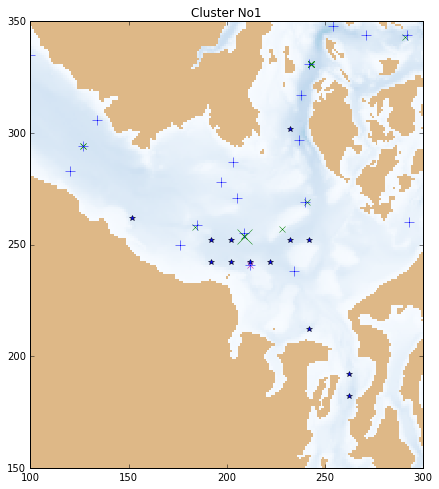

In [181]:
cluster = 1
imin = 150; imax=350; jmin=100; jmax=300
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], '*')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15)
cluster_1 = {'NEMO grid ji': (241, 212)}
ax.plot(cluster_1['NEMO grid ji'][1], cluster_1['NEMO grid ji'][0] , 'xm')
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

In [182]:
cluster_1['lon lat'] = (nav_lat[cluster_1['NEMO grid ji']],
                        nav_lon[cluster_1['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_1['NEMO grid ji'][1] and y == cluster_1['NEMO grid ji'][0]:
        cluster_1['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_1)

{'NEMO grid ji': (241, 212), 'lon lat': (48.214740753173828, -123.09858703613281), 'Vector Stn': '64'}


### Cluster 2

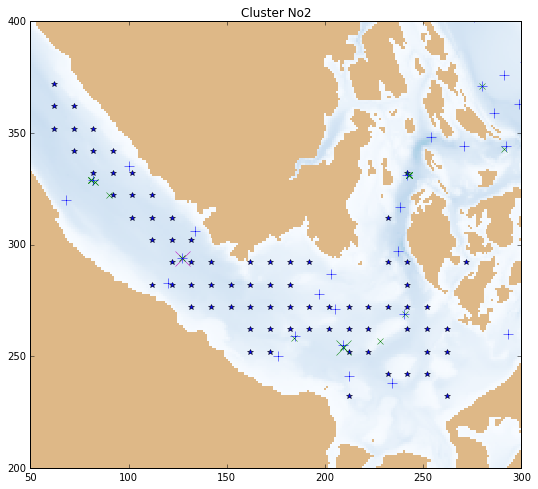

In [183]:
cluster = 2
imin = 200; imax=400; jmin=50; jmax=300
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], '*')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15)
cluster_2 = {'NEMO grid ji': (294, 127)}
ax.plot(cluster_2['NEMO grid ji'][1], cluster_2['NEMO grid ji'][0] , 'xm', markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

In [184]:
cluster_2['lon lat'] = (nav_lat[cluster_2['NEMO grid ji']],
                        nav_lon[cluster_2['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_2['NEMO grid ji'][1] and y == cluster_2['NEMO grid ji'][0]:
        cluster_2['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_2)

{'NEMO grid ji': (294, 127), 'lon lat': (48.260612487792969, -123.71742248535156), 'Vector Stn': '69'}


### Cluster 3

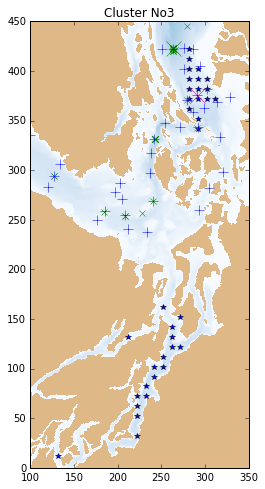

In [185]:
cluster = 3
imin = 0; imax=450; jmin=100; jmax=350
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster], '*')
ax.set_title('Cluster No' + str(cluster));
ax.plot(places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][1], 
        places.PLACES['Cluster_'+str(cluster)]['NEMO grid ji'][0], 'x', markersize=15)
cluster_3 = {'NEMO grid ji': (376, 291)}
ax.plot(cluster_3['NEMO grid ji'][1], cluster_3['NEMO grid ji'][0] , 'xm', markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

In [186]:
cluster_3['lon lat'] = (nav_lat[cluster_3['NEMO grid ji']],
                        nav_lon[cluster_3['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_3['NEMO grid ji'][1] and y == cluster_3['NEMO grid ji'][0]:
        cluster_3['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_3)

{'NEMO grid ji': (376, 291), 'lon lat': (48.899330139160156, -123.13800048828125), 'Vector Stn': '45'}


### Cluster 4

(0, 897)

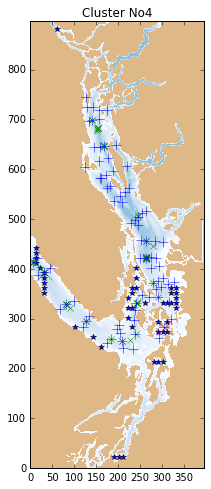

In [187]:
cluster = 4
imin = 0
imax = 897
jmin = 0
jmax = 397
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        '*')
#ax.plot(d_stn_x, d_stn_y, '.')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'x',
    markersize=15)
cluster_4 = {'NEMO grid ji': (282, 305)}
ax.plot(
    cluster_4['NEMO grid ji'][1],
    cluster_4['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

In [188]:
cluster_4['lon lat'] = (nav_lat[cluster_4['NEMO grid ji']],
                        nav_lon[cluster_4['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_4['NEMO grid ji'][1] and y == cluster_4['NEMO grid ji'][0]:
        cluster_4['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_4)

{'NEMO grid ji': (282, 305), 'lon lat': (48.554798126220703, -122.74989318847656), 'Vector Stn': '53'}


### Cluster 5

(200, 400)

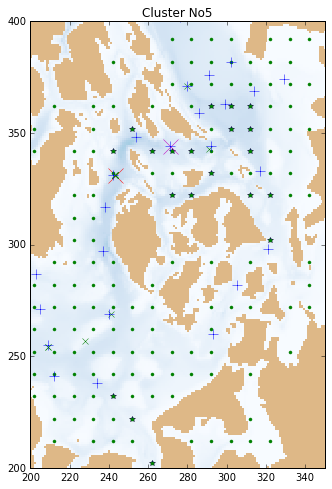

In [189]:
cluster = 5
imin = 200
imax = 400
jmin = 200
jmax = 350

ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        '*')
ax.plot(d_stn_x, d_stn_y, '.')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'x',
    markersize=15)
cluster_5 = {'NEMO grid ji': (344, 271)}
ax.plot(
    cluster_5['NEMO grid ji'][1],
    cluster_5['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

In [190]:
cluster_5['lon lat'] = (nav_lat[cluster_5['NEMO grid ji']],
                        nav_lon[cluster_5['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_5['NEMO grid ji'][1] and y == cluster_5['NEMO grid ji'][0]:
        cluster_5['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_5)

{'NEMO grid ji': (344, 271), 'lon lat': (48.735176086425781, -123.13486480712891), 'Vector Stn': '57'}


### Cluster 6

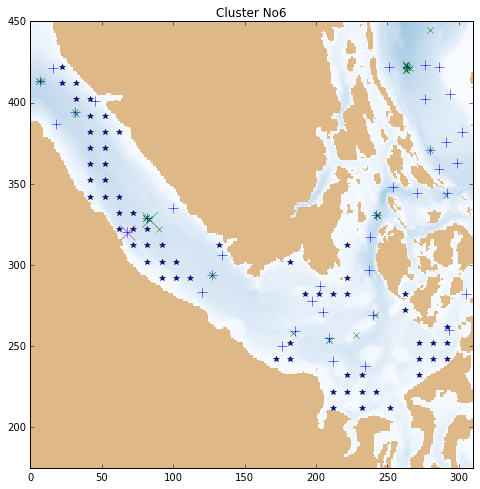

In [191]:
cluster = 6
imin = 175
imax = 450
jmin = 0
jmax = 310
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster],
        d_stn_y[bio_non_norm == cluster], '*')
#ax.plot(d_stn_x, d_stn_y, '.')
ax.set_title('Cluster No' + str(cluster))
ax.plot(places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
        places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
        'x',
    markersize=15)
cluster_6 = {'NEMO grid ji': (320, 68)}
ax.plot(
    cluster_6['NEMO grid ji'][1],
    cluster_6['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

In [192]:
cluster_6['lon lat'] = (nav_lat[cluster_6['NEMO grid ji']],
                        nav_lon[cluster_6['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_6['NEMO grid ji'][1] and y == cluster_6['NEMO grid ji'][0]:
        cluster_6['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_6)

{'NEMO grid ji': (320, 68), 'lon lat': (48.248786926269531, -124.11007690429688), 'Vector Stn': '73'}


### Cluster 7

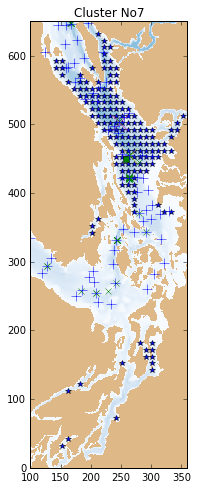

In [193]:
cluster = 7
imin = 0
imax = 650
jmin = 100
jmax = 360
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        '*')
#ax.plot(d_stn_x, d_stn_y, '.')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'xy',
    markersize=15)
ax.plot(places.PLACES['S3']['NEMO grid ji'][1],
        places.PLACES['S3']['NEMO grid ji'][0], 'gs')
cluster_7 = {'NEMO grid ji': (504, 246)}
ax.plot(
    cluster_7['NEMO grid ji'][1],
    cluster_7['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax));

In [194]:
cluster_7['lon lat'] = (nav_lat[cluster_7['NEMO grid ji']],
                        nav_lon[cluster_7['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_7['NEMO grid ji'][1] and y == cluster_7['NEMO grid ji'][0]:
        cluster_7['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_7)

{'NEMO grid ji': (504, 246), 'lon lat': (49.316856384277344, -123.80063629150391), 'Vector Stn': '27'}


### Cluster 8

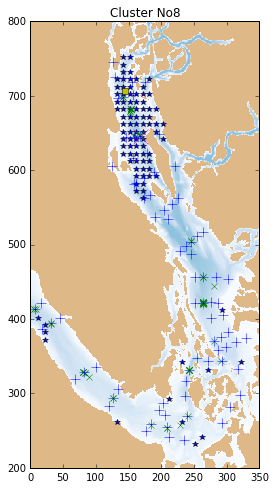

In [195]:
cluster = 8
imin = 200
imax = 800
jmin = 0
jmax = 350
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster], d_stn_y[bio_non_norm == cluster],
        '*')
ax.set_title('Cluster No' + str(cluster))
ax.plot(
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
    places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
    'g.')
cluster_8 = {'NEMO grid ji': (646, 168)}
ax.plot(
    cluster_8['NEMO grid ji'][1],
    cluster_8['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))
ax.plot(places.PLACES['Sentry Shoal']['NEMO grid ji'][1],
        places.PLACES['Sentry Shoal']['NEMO grid ji'][0], 'ys');

In [196]:
cluster_8['lon lat'] = (nav_lat[cluster_8['NEMO grid ji']],
                        nav_lon[cluster_8['NEMO grid ji']])
for i, (x, y) in enumerate(zip(vector_x, vector_y)):
    if x == cluster_8['NEMO grid ji'][1] and y == cluster_8['NEMO grid ji'][0]:
        cluster_8['Vector Stn'] = vectorlines[i].split(' ', 1)[0]
print(cluster_8)

{'NEMO grid ji': (646, 168), 'lon lat': (49.725547790527344, -124.67886352539062), 'Vector Stn': '12'}


### Cluster 9

(0, 897)

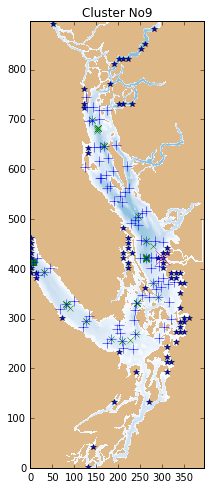

In [197]:
cluster = 9
imin = 0
imax = 897
jmin = 0
jmax = 397
ax = background_map()
ax.plot(d_stn_x[bio_non_norm == cluster],
        d_stn_y[bio_non_norm == cluster], '*')
ax.set_title('Cluster No' + str(cluster))
ax.plot(places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][1],
        places.PLACES['Cluster_' + str(cluster)]['NEMO grid ji'][0],
        'gs')
cluster_9 = {'NEMO grid ji': (423, 300)}
ax.plot(
    cluster_9['NEMO grid ji'][1],
    cluster_9['NEMO grid ji'][0],
    'xm',
    markersize=15)
ax.plot(debby_x, debby_y, 'gx')
ax.plot(vector_x, vector_y, 'b+', markersize=10)
ax.set_xlim((jmin, jmax))
ax.set_ylim((imin, imax))

In [198]:
cluster_9['lon lat'] = (nav_lat[cluster_9['NEMO grid ji']],
                        nav_lon[cluster_9['NEMO grid ji']])
print(cluster_9)

{'NEMO grid ji': (423, 300), 'lon lat': (49.101184844970703, -123.24888610839844)}


## Final Places Map

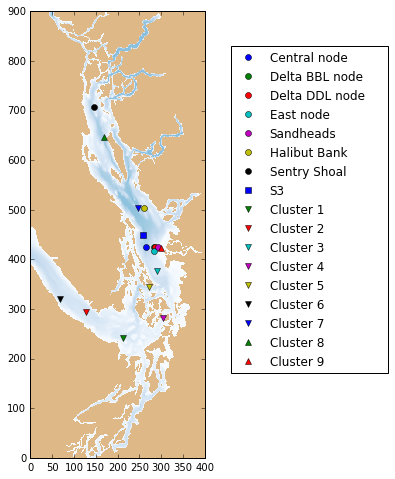

In [199]:
reload(places)
water_places = ['Central node', 'Delta BBL node', 'Delta DDL node', 'East node','Sandheads', \
               'Halibut Bank', 'Sentry Shoal', 'S3']
clusters = [cluster_1, cluster_2,
          cluster_3, cluster_4, cluster_5, cluster_6, cluster_7, cluster_8, cluster_9]
ax = background_map()

for countpoint, place in enumerate(water_places):
    point = places.PLACES[place]['NEMO grid ji']
    if countpoint < 7:
        ax.plot(point[1], point[0], 'o', label=place)
    else:
        ax.plot(point[1], point[0], 's', label=place)

for countpoint, place in enumerate(clusters):
    point = place['NEMO grid ji']
    if countpoint < 7:
        ax.plot(point[1], point[0], 'v', label='Cluster '+str(countpoint+1))
    else:
        ax.plot(point[1], point[0], '^', label='Cluster '+str(countpoint+1))
    
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 0.82, 0.9, .102), ncol=1, mode="expand", borderaxespad=0., numpoints=1);

In [210]:
print (cluster_9)

{'NEMO grid ji': (423, 300), 'lon lat': (49.101184844970703, -123.24888610839844)}
